In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk_test.test_overeager_arrival.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0     de056cdf-6ff0-4eeb-a9bc-2c8a52589f30
1     0b97488f-791c-483f-a48d-62bd169e6fc9
2     a08151fe-90e5-4820-b109-6611ae291f7e
3     c1fb35a7-b984-4b88-89ba-3b15b2e1369c
4     1d2f3cbc-5062-40c2-8992-17058fae74ac
5     bf8744de-e563-4bb0-bbff-184c15ee9777
6     8b4342c5-1894-4975-a5d8-65d58e5c70b4
7     9fac0d05-f96a-4410-8167-da3921aa22e8
8     18daca2e-aac8-4613-aa8d-0aa7a1e3691e
9     e37ec702-2d8a-4f8b-b295-5b2ec1fab510
10    ce2c7bd2-5196-4aac-b217-5d71c8227c67
11    b8178602-fa02-4a2d-a14c-158bb814e9af
12    114fb290-7fd6-4083-bda2-8a746771ee03
13    6466900c-ccf7-4f01-9b57-0582c663e271
14    b455f7a0-964b-4042-ae15-73e254aa4a72
15    95e4bb49-b0ba-4fc7-9343-e2f789f33397
16    b49a99fb-494e-427a-8046-eb06f45b4f13
17    18789ba4-7782-4d99-a513-115c2c7f40f1
18    8db52255-b098-4720-b90f-bab6cfec1722
dtype: object

In [4]:
targets = eids[pd.Series(df_base["eid"].unique()).str.startswith("9fac")]
targets

7    9fac0d05-f96a-4410-8167-da3921aa22e8
dtype: object

In [5]:
target_index = targets.index[0]

In [6]:
target_eid = df_base["eid"].unique()[target_index]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['9fac0d05-f96a-4410-8167-da3921aa22e8'], dtype=object)

In [7]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
    o_dv = pd.DataFrame(np.vstack(df_base["o._dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o._dv.x", "o._dv.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    o_dv = pd.DataFrame({"o._dv": empty_array, "o._dv.x": empty_array, "o._dv.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
desired_angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["o._ada"])), axis=1)), columns=["_ada.x", "_ada.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, o_dv, angle, desired_angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.cbdr_hist"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    df["o.nd"] = empty_array
    df["o.ct_dist"] = empty_array
    df["o.ct_cn"] = empty_array
    df["o.ct_ms"] = empty_array
    
else:
    df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array
    df["o.t_dist"] = empty_array
    df["o.msc"] = empty_array
    df["o.max_speed_cap"] = empty_array
else:
    df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
    df["o.max_speed_cap"] = (df["o.msc"]*(1+df["o.msc_a"])**(df["ts"] - df["o.msc_ts"])).clip(upper=3000)
    


In [8]:
df["f"] = df["f"].apply(lambda x: [x["x"],x["y"]])

In [9]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["o._dv_speed"] = np.linalg.norm(df[["o._dv.x", "o._dv.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [10]:
#df["o.ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
#df["o.ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [11]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.movement.GoToLocation',
 'nd': 2.984155182973037e-08,
 'nnd': 524.5782318498955,
 '_nact': 0.0,
 '_ada': 0.0,
 't_loc': [-21684.42275167689, 31317.42010677473],
 'ad': 500.0,
 'md': 0.0,
 't_v': [-41.592045575106944, 73.61827703048125],
 'cs': False,
 'scm': 200.0,
 '_ncts': 49.98571428571402,
 '_dv': [-41.592045575106944, 73.61827703048125],
 'msc': 100.0,
 'msc_ts': 49.39999999999976,
 'msc_a': 0.2}

# Basic Ship Vitals

## Position and Heading

In [12]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=49.96666666666639, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

In [13]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,1499.000000,1499.000000
mean,-20928.583393,30600.150499
std,393.163623,93.491678
min,-21404.630859,30415.945312
25%,-21168.087891,30497.427734
50%,-21087.708984,30633.025391
75%,-20752.919922,30669.500977
max,-19969.226562,30736.361328


Text(0.5, 1.0, 'position')

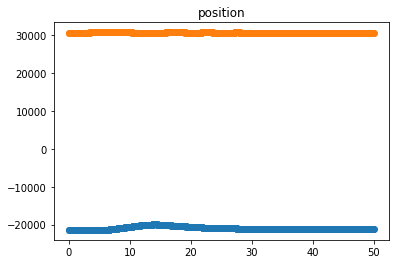

In [14]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

In [15]:
def plot_heading(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["a"].apply(lambda x: util.normalize_angle(x, shortest=True)), label="theta")
    plt.scatter(sample["ts"], sample["av"], label="omega")
    plt.scatter(sample["ts"], sample["o._ada"].apply(lambda x: util.normalize_angle(x, shortest=True)), label="desired theta")
    plt.hlines(np.pi, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.hlines(0, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.legend()
    plt.title("heading and angular velocity")
    
ipywidgets.interact(plot_heading, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_heading(hist_length, max_time)>

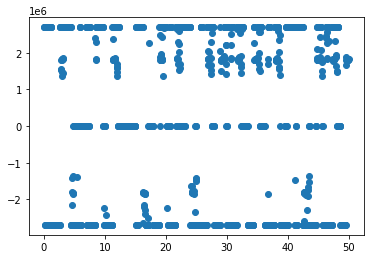

In [16]:
plt.scatter(df["ts"], df["t"])

In [17]:
(df["t"] == 0).value_counts()

False    1221
True      278
Name: t, dtype: int64

In [18]:
((df["t"].abs() == 2700000.0) | (df["t"] == 0)).value_counts()

True     1216
False     283
Name: t, dtype: int64

### Velocity and Acceleration

In [19]:
def plot_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"])
    plt.title("speed")
    print(f'min speed: {sample["speed"].min()}')
    print(f'max speed: {sample["speed"].max()}')
    
ipywidgets.interact(plot_speed, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_speed(hist_length, max_time)>

In [20]:
def plot_velocity(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["v.x"], label="x")
    plt.scatter(sample["ts"], sample["v.y"], label="y")
    plt.legend()
    plt.title("velocity")
    
ipywidgets.interact(plot_velocity, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_velocity(hist_length, max_time)>

In [21]:
def plot_acceleration(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (sample["v.x"].shift(1) - sample["v.x"]) / (sample["ts"].shift(1) - sample["ts"]), label="x")
    plt.scatter(sample["ts"], (sample["v.y"].shift(1) - sample["v.y"]) / (sample["ts"].shift(1) - sample["ts"]), label="y")
    plt.yscale("symlog")
    plt.legend()
    plt.title("acceleration")
    
ipywidgets.interact(plot_acceleration, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_acceleration(hist_length, max_time)>

In [22]:
def plot_force(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["f_mag"])
    plt.yscale("log")
    plt.title("force")
    print(f'min force={sample["f_mag"].min()}')
    print(f'max force={sample["f_mag"].max()}')

ipywidgets.interact(plot_force, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_force(hist_length, max_time)>

# Behavior Monitoring

In [23]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[0.033333333333333, None, 0.16666666666666602, None]

In [24]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.scatter(sample["ts"], sample["o.cach"].fillna(0).astype(int)+0.1, label="cach", marker="+")
    plt.scatter(sample["ts"], sample["o.ct_dv_override"].fillna(0).astype(int)+0.2, label="dv override")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cach", "o.cbdr", "o.ct_dv_override"]
    first_ts = [
        next(
            (sample.loc[idx]["ts"] if idx is not None else None
             for idx, v in zip(sample.index, (~sample[c].isna() & sample[c] == True))
             if v),
            None
        )
        for c in flag_cols
    ]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [25]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"], "o.ad":["min"]})
else:
    x = "no location target"
x

ts                         o.t_dist              \
                           count       min        max         min         max   
o.t_loc.x     o.t_loc.y                                                         
-21684.422752 31317.420107  1499  0.033333  49.966667  655.212504  1863.84378   

                             o.ad  
                              min  
o.t_loc.x     o.t_loc.y            
-21684.422752 31317.420107  500.0

In [26]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.scatter(sample["ts"], sample["o.ad"], color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.md"], color="red", marker="_")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(f'when first arrived {sample[sample["o.t_dist"] < sample["o.ad"]]["ts"].min()}')

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_target_distance(hist_length, max_time)>

In [27]:
df[df["o.t_dist"] < df["o.ad"]]["ts"].min()

nan

In [51]:
def plot_desired_speed(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["speed"], label="actual speed")
    plt.scatter(sample["ts"], sample["o.t_speed"], label="desired speed")
    plt.scatter(sample["ts"], sample["o.max_speed_cap"], label="max speed cap")
    plt.scatter(sample["ts"], sample["o._dv_speed"], label="desired speed (_dv)")
    plt.legend()
    plt.title("speed and desired speed to target")
    plt.ylim(0)

ipywidgets.interact(
    plot_desired_speed,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_desired_speed(hist_length, max_time)>

Text(0.5, 1.0, 'desired speed delta')

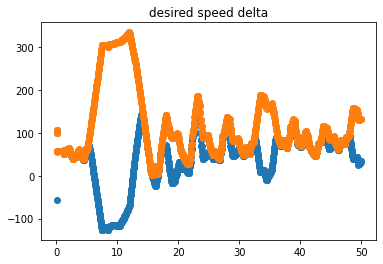

In [29]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

### Collision Threats

In [30]:
def show_collision_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    if np.any(~sample["o.ct"].isna()):
        x = sample.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
    else:
        x = "no collision threats"
    return x
ipywidgets.interact(
    show_collision_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.show_collision_threats(hist_length, max_time)>

In [31]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"]*2, color="green", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"]+sample["o.scm"], color="orange", marker="_")
    plt.scatter(sample["ts"], sample["o.ct_cradius"], color="red", marker="_")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(f'max ct dist: {sample["o.ct_dist"].max()}')
    print(f'min ct dist: {sample["o.ct_dist"].min()}')

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_collision_distance(hist_length, max_time)>

In [32]:
def plot_minimum_separation(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ms"])
    #plt.scatter(sample["ts"], sample["o.ct_cradius"]+30, color="red", marker="_")
    plt.ylim(0)
    plt.title("minimum_separation with collision threat")
    print(f'max min sep: {sample["o.ct_ms"].max()}')
    print(f'min min sep: {sample["o.ct_ms"].min()}')

ipywidgets.interact(
    plot_minimum_separation,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_minimum_separation(hist_length, max_time)>

In [33]:
def plot_threat_age(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.scatter(sample["ts"], 1-sample["o.ct"].isna().astype(int))
    ax2.scatter(sample["ts"], sample["ts"] - sample["o.ct_ts"], color="orange")
    plt.title("Collision Threat and Time Since Detection")

    #ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)
    
ipywidgets.interact(
    plot_threat_age,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_threat_age(hist_length, max_time)>

## CBDR Detection

In [34]:
def plot_cbdr_detection_data(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    bearing = sample["o.cbdr_hist"].apply(lambda x: np.nan if isinstance(x, float) or len(x) < 2 else abs(util.cartesian_to_polar(x[0][0], x[0][1])[1] - util.cartesian_to_polar(x[-1][0], x[-1][1])[1]))
    threat_range = sample["o.cbdr_hist"].apply(lambda x: np.nan if isinstance(x, float) or len(x) < 2 else util.cartesian_to_polar(x[0][0], x[0][1])[0] - util.cartesian_to_polar(x[-1][0], x[-1][1])[0])
    ax1.scatter(sample["ts"], bearing, label="delta bearing")
    ax1.hlines(2e-3, sample["ts"].min(), sample["ts"].max(), color="green", label="max delta bearing")
    ax2.scatter(sample["ts"], threat_range, color="orange", label="delta range")
    ax2.hlines(5, sample["ts"].min(), sample["ts"].max(), color="red", label="min delta range")
    fig.legend()
    
ipywidgets.interact(
    plot_cbdr_detection_data,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_cbdr_detection_data(hist_length, max_time)>

In [35]:
def plot_num_coalesced_threats(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_ct"])
    plt.title("number of coalesced threats")
    plt.show()

ipywidgets.interact(
    plot_num_coalesced_threats,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)  

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_num_coalesced_threats(hist_length, max_time)>

In [36]:
def plot_collision_threat_radius(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], sample["o.scm"], label="desired margin")
    plt.title("collision threat radius")
    plt.legend()
    print(f'min coalesced radius: {sample["o.ct_cradius"].min()}')
    print(f'min scaled margin: {sample["o.scm"].min()}')
    plt.show()

ipywidgets.interact(
    plot_collision_threat_radius,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_collision_threat_radius(hist_length, max_time)>

In [37]:
def plot_collision_threat_loc(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.scatter(sample["ts"], sample["o.ct_cloc.x"])
    ax2.scatter(sample["ts"], sample["o.ct_cloc.y"], color="orange")
    plt.title("collision threat coalesced location")
    plt.show()

ipywidgets.interact(
    plot_collision_threat_loc,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_collision_threat_loc(hist_length, max_time)>

In [38]:
df[(df["o.ct_cloc.x"]-df["o.ct_cloc.x"].shift(1)).abs() > 30]

,index,p,eid,ts,loc,r,a,v,av,f,...,angle.y,_ada.x,_ada.y,o.ct_dist,o.t_dist,o.max_speed_cap,speed,o.t_speed,o._dv_speed,f_mag
4,3012,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.166667,"[-21361.291015625, 30545.44140625]",30,-57.933679,"[-12.533207893371582, 40.7727165222168]",0.054310,"[-12646.902765345241, -8065.720702076344]",...,-98.279153,100.0,0.0,127.510839,836.878266,100.609589,42.655547,100.000000,2988.925805,15000.0
12,3020,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.433333,"[-21364.611328125, 30556.306640625]",30,-57.912530,"[-11.58014965057373, 41.10374450683594]",0.454310,"[-12625.308234486054, -8099.480970051022]",...,-97.866534,100.0,0.0,124.273730,825.574379,100.609589,42.703837,100.000000,2987.831521,15000.0
20,3028,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.700000,"[-21367.671875, 30567.25]",30,-57.784713,"[-10.573969841003418, 41.29496765136719]",0.854310,"[-12611.621123057259, -8120.77660377725]",...,-94.449224,100.0,0.0,120.942675,814.301116,100.609589,42.627259,100.000000,2986.807688,15000.0
28,3036,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.966667,"[-21370.4609375, 30578.228515625]",30,-57.550231,"[-9.520678520202637, 41.30107498168945]",1.254310,"[-12603.427719897452, -8133.486934231865]",...,-84.231436,100.0,0.0,117.529877,803.104121,100.609589,42.384220,100.000000,2985.870893,15000.0
36,3044,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,1.233333,"[-21372.96484375, 30589.1875]",30,-57.209081,"[-8.442233085632324, 41.03345489501953]",1.654311,"[-12596.797210666604, -8143.752208493455]",...,-61.344334,100.0,0.0,114.061267,792.040882,100.609589,41.892908,92.285559,2985.067258,15000.0
44,3052,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,1.500000,"[-21375.193359375, 30600.021484375]",30,-56.861265,"[-7.587891578674316, 40.02744674682617]",0.854310,"[-12644.054128793709, -8070.185573339363]",...,-30.753100,100.0,0.0,111.336454,781.206503,100.609589,40.740307,100.000000,2985.100482,15000.0
52,3060,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,1.766667,"[-21377.212890625, 30610.556640625]",30,-56.726782,"[-6.861176013946533, 38.79323959350586]",0.054310,"[-12748.51392525422, -7904.137694751986]",...,-17.717411,100.0,0.0,109.776121,770.735920,100.609589,39.395319,100.000000,2985.613684,15000.0
60,3068,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,2.033333,"[-21379.037109375, 30620.765625]",30,-56.805633,"[-6.11170482635498, 37.59667205810547]",-0.745690,"[-9295.641712729173, -11772.469798159154]",...,-25.414633,100.0,0.0,140.958829,760.649629,100.609589,38.090191,100.000000,2974.413131,15000.0
96,3104,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,3.233333,"[-21390.57421875, 30662.837890625]",30,-58.879359,"[-13.65354061126709, 32.825592041015625]",-1.167996,"[12966.579878128643, -7541.074609371626]",...,-72.490855,100.0,0.0,205.383011,717.512953,100.609589,35.551915,82.554333,2971.772527,15000.0
222,3230,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,7.433333,"[-21150.51171875, 30732.75]",30,-56.652038,"[226.1939239501953, -8.224906921386719]",0.026762,"[-14459.453140961632, -3990.5156138442544]",...,-10.318645,100.0,0.0,507.456771,791.770248,100.609589,226.343412,100.000000,71.936400,15000.0


In [39]:
ctxloc_diff_s = (df["o.ct_cloc.x"]-df["o.ct_cloc.x"].shift(1)).abs()
ctxloc_diff_s[ctxloc_diff_s > 30]

4       297.327794
12      308.103516
20      302.128906
28      296.406250
36      290.937500
44      286.771484
52      284.201172
60      276.431641
96      285.806641
222     859.035156
465     114.171875
468     111.316406
471      93.832031
474      80.716797
477     194.910156
627     113.525391
780     105.287109
930     105.287109
1113    105.287109
1200    328.445312
1245    105.287109
1401    105.287109
Name: o.ct_cloc.x, dtype: float64

In [40]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_collision_dv(hist_length, max_time)>

In [41]:
df[(df["o.ct_dv.x"]-df["o.ct_dv.x"].shift(1)).abs() > 250]

,index,p,eid,ts,loc,r,a,v,av,f,...,angle.y,_ada.x,_ada.y,o.ct_dist,o.t_dist,o.max_speed_cap,speed,o.t_speed,o._dv_speed,f_mag
1,3009,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.066667,"[-21359.8046875, 30540.740234375]",30,-57.919110,"[-16.02910041809082, 50.141746520996094]",-0.245690,"[69917.83891058309, -187380.61746635847]",...,-97.999617,100.0,0.0,547.231760,841.788876,3000.000000,52.641493,153.358182,2947.419512,200000.0
4,3012,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.166667,"[-21361.291015625, 30545.44140625]",30,-57.933679,"[-12.533207893371582, 40.7727165222168]",0.054310,"[-12646.902765345241, -8065.720702076344]",...,-98.279153,100.0,0.0,127.510839,836.878266,100.609589,42.655547,100.000000,2988.925805,15000.0
12,3020,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.433333,"[-21364.611328125, 30556.306640625]",30,-57.912530,"[-11.58014965057373, 41.10374450683594]",0.454310,"[-12625.308234486054, -8099.480970051022]",...,-97.866534,100.0,0.0,124.273730,825.574379,100.609589,42.703837,100.000000,2987.831521,15000.0
20,3028,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.700000,"[-21367.671875, 30567.25]",30,-57.784713,"[-10.573969841003418, 41.29496765136719]",0.854310,"[-12611.621123057259, -8120.77660377725]",...,-94.449224,100.0,0.0,120.942675,814.301116,100.609589,42.627259,100.000000,2986.807688,15000.0
28,3036,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,0.966667,"[-21370.4609375, 30578.228515625]",30,-57.550231,"[-9.520678520202637, 41.30107498168945]",1.254310,"[-12603.427719897452, -8133.486934231865]",...,-84.231436,100.0,0.0,117.529877,803.104121,100.609589,42.384220,100.000000,2985.870893,15000.0
36,3044,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,1.233333,"[-21372.96484375, 30589.1875]",30,-57.209081,"[-8.442233085632324, 41.03345489501953]",1.654311,"[-12596.797210666604, -8143.752208493455]",...,-61.344334,100.0,0.0,114.061267,792.040882,100.609589,41.892908,92.285559,2985.067258,15000.0
41,3049,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,1.400000,"[-21374.3984375, 30595.986328125]",30,-56.966696,"[-8.151453971862793, 40.52231979370117]",1.154310,"[11271.237958300268, -9897.43375261341]",...,-40.595927,100.0,0.0,257.802381,785.227211,100.609589,41.334061,97.675320,2967.242983,15000.0
44,3052,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,1.500000,"[-21375.193359375, 30600.021484375]",30,-56.861265,"[-7.587891578674316, 40.02744674682617]",0.854310,"[-12644.054128793709, -8070.185573339363]",...,-30.753100,100.0,0.0,111.336454,781.206503,100.609589,40.740307,100.000000,2985.100482,15000.0
52,3060,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,1.766667,"[-21377.212890625, 30610.556640625]",30,-56.726782,"[-6.861176013946533, 38.79323959350586]",0.054310,"[-12748.51392525422, -7904.137694751986]",...,-17.717411,100.0,0.0,109.776121,770.735920,100.609589,39.395319,100.000000,2985.613684,15000.0
60,3068,SHP,9fac0d05-f96a-4410-8167-da3921aa22e8,2.033333,"[-21379.037109375, 30620.765625]",30,-56.805633,"[-6.11170482635498, 37.59667205810547]",-0.745690,"[-9295.641712729173, -11772.469798159154]",...,-25.414633,100.0,0.0,140.958829,760.649629,100.609589,38.090191,100.000000,2974.413131,15000.0


## Nearest Neighbors

In [42]:
neighborhood_radius = 5e4
def plot_neighborhood_size(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nd"]*np.pi*neighborhood_radius**2)
    plt.title("neighborhood size (10km^2)")
    plt.show()

ipywidgets.interact(
    plot_neighborhood_size,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_neighborhood_size(hist_length, max_time)>

In [43]:
def plot_nearest_neighbor(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.nnd"], label="nearest neighbor dist")
    plt.scatter(sample["ts"], sample["o.scm"], label="desired margin")
    plt.title("nearest neighor dist")
    plt.legend()
    plt.show()
    print(f'min dist {sample["o.nnd"].min()}')

ipywidgets.interact(
    plot_nearest_neighbor,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_nearest_neighbor(hist_length, max_time)>

In [44]:
# 
# Smallest enclosing circle - Library (Python)
# 
# Copyright (c) 2020 Project Nayuki
# https://www.nayuki.io/page/smallest-enclosing-circle
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
# 
# You should have received a copy of the GNU Lesser General Public License
# along with this program (see COPYING.txt and COPYING.LESSER.txt).
# If not, see <http://www.gnu.org/licenses/>.
# 

import math, random


# Data conventions: A point is a pair of floats (x, y). A circle is a triple of floats (center x, center y, radius).

# Returns the smallest circle that encloses all the given points. Runs in expected O(n) time, randomized.
# Input: A sequence of pairs of floats or ints, e.g. [(0,5), (3.1,-2.7)].
# Output: A triple of floats representing a circle.
# Note: If 0 points are given, None is returned. If 1 point is given, a circle of radius 0 is returned.
# 
# Initially: No boundary points known
def make_circle(points):
	# Convert to float and randomize order
	shuffled = [(float(x), float(y)) for (x, y) in points]
	random.shuffle(shuffled)
	
	# Progressively add points to circle or recompute circle
	c = None
	for (i, p) in enumerate(shuffled):
		if c is None or not is_in_circle(c, p):
			c = _make_circle_one_point(shuffled[ : i + 1], p)
	return c


# One boundary point known
def _make_circle_one_point(points, p):
	c = (p[0], p[1], 0.0)
	for (i, q) in enumerate(points):
		if not is_in_circle(c, q):
			if c[2] == 0.0:
				c = make_diameter(p, q)
			else:
				c = _make_circle_two_points(points[ : i + 1], p, q)
	return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
	circ = make_diameter(p, q)
	left  = None
	right = None
	px, py = p
	qx, qy = q
	
	# For each point not in the two-point circle
	for r in points:
		if is_in_circle(circ, r):
			continue
		
		# Form a circumcircle and classify it on left or right side
		cross = _cross_product(px, py, qx, qy, r[0], r[1])
		c = make_circumcircle(p, q, r)
		if c is None:
			continue
		elif cross > 0.0 and (left is None or _cross_product(px, py, qx, qy, c[0], c[1]) > _cross_product(px, py, qx, qy, left[0], left[1])):
			left = c
		elif cross < 0.0 and (right is None or _cross_product(px, py, qx, qy, c[0], c[1]) < _cross_product(px, py, qx, qy, right[0], right[1])):
			right = c
	
	# Select which circle to return
	if left is None and right is None:
		return circ
	elif left is None:
		return right
	elif right is None:
		return left
	else:
		return left if (left[2] <= right[2]) else right


def make_diameter(a, b):
	cx = (a[0] + b[0]) / 2
	cy = (a[1] + b[1]) / 2
	r0 = math.hypot(cx - a[0], cy - a[1])
	r1 = math.hypot(cx - b[0], cy - b[1])
	return (cx, cy, max(r0, r1))


def make_circumcircle(a, b, c):
	# Mathematical algorithm from Wikipedia: Circumscribed circle
	ox = (min(a[0], b[0], c[0]) + max(a[0], b[0], c[0])) / 2
	oy = (min(a[1], b[1], c[1]) + max(a[1], b[1], c[1])) / 2
	ax = a[0] - ox;  ay = a[1] - oy
	bx = b[0] - ox;  by = b[1] - oy
	cx = c[0] - ox;  cy = c[1] - oy
	d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
	if d == 0.0:
		return None
	x = ox + ((ax*ax + ay*ay) * (by - cy) + (bx*bx + by*by) * (cy - ay) + (cx*cx + cy*cy) * (ay - by)) / d
	y = oy + ((ax*ax + ay*ay) * (cx - bx) + (bx*bx + by*by) * (ax - cx) + (cx*cx + cy*cy) * (bx - ax)) / d
	ra = math.hypot(x - a[0], y - a[1])
	rb = math.hypot(x - b[0], y - b[1])
	rc = math.hypot(x - c[0], y - c[1])
	return (x, y, max(ra, rb, rc))


_MULTIPLICATIVE_EPSILON = 1 + 1e-14

def is_in_circle(c, p):
	return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
	return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)

In [45]:
def plot_radius_comparison(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    foo = sample["o.ct_cn"].apply(lambda x: np.nan if isinstance(x, float) else make_circle(x)[2]+30)
    plt.scatter(sample["ts"], sample["o.ct_cradius"], label="threat radius")
    plt.scatter(sample["ts"], sample["o.scm"], label="threat radius")
    plt.scatter(sample["ts"], foo, label="min radius", marker="x")
    plt.legend()
    plt.title("cradius vs smallest enclosing radius")
    plt.show()

ipywidgets.interact(
    plot_radius_comparison,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_radius_comparison(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [46]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True, show_cn=True, show_all_cts=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    scale = None
    if show_v:
        q = plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], scale=scale, units="inches", label="v")
        q._init()
        scale = q.scale
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    if show_ctdv:
        q = plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], scale=scale, units="inches", label="ctdv", color="orange")
        q._init()
        scale = q.scale
    if show_tv:
        q = plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], scale=scale, units="inches", label="tv", color="purple")
        q._init()
        scale = q.scale
    
    
    if show_all_cts:
        ctv_df = sample
    else:
        ctv_df = sample[sample["o.ct"] == sample.iloc[-1]["o.ct"]]
    q = plt.quiver(ctv_df["o.ct_loc.x"], ctv_df["o.ct_loc.y"], ctv_df["o.ct_v.x"], ctv_df["o.ct_v.y"], scale=scale, units="inches", label="ctv", color="cyan")
    q._init()
    scale = q.scale
    
    if show_all_cts:
        cts = df["o.ct"].unique()
    else:
        cts = [sample.iloc[-1]["o.ct"]]
        
    cmap = plt.get_cmap('viridis')
    for x, c in zip(cts, cmap(np.linspace(0, 1, len(cts)))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if not np.allclose((x, y), (x_next, y_next)):
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
    
    cloc_df = sample#[~(sample["o.ct_cloc"].isna())]
    if not isinstance(cloc_df.iloc[-1]["o.ct"], float):
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        cmargin = cloc_df.iloc[-1].get(["o.scm"],500)
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+cmargin, color="orange", fill=False)
        margin_hist = plt.Circle((cloc_x, cloc_y), cradius+cmargin*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
        plt.gca().add_patch(margin_hist)
        print(f'{cradius=}')
        
        if show_cn:
            cn_x, cn_y = list(zip(*cloc_df.iloc[-1]["o.ct_cn"]))
            plt.scatter(cn_x, cn_y, label="ct_cnloc", marker="+", color="pink")
    
    if show_tloc and not all(sample["o.t_loc.x"].isna()):
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc", marker="x")
        for ((tloc_x, tloc_y), ad, md) in sample.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"o.t_loc": "min", "o.ad":"min", "o.md":"min"}).values:
            arrival_dist = plt.Circle((tloc_x, tloc_y), ad, color="green", fill=False)
            nearby_dist = plt.Circle((tloc_x, tloc_y), ad*5, color="green", ls="--", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), md, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(nearby_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = hist_length
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if not np.allclose((x, y), (x_next, y_next)):
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-72000, -50000)
    #radius = 20000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=2, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
    show_tv=ipywidgets.Checkbox(value=True),
    show_ctdv=ipywidgets.Checkbox(value=True),
    show_v=ipywidgets.Checkbox(value=True),
    show_cn=ipywidgets.Checkbox(value=True),
    show_all_cts=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_collision_chart(hist_length=49.96666666666639, max_time=49.96666666666639, sampling_interval=50, show_tloc=True, show_tv=True, show_ctdv=True, show_v=True, show_cn=True, show_all_cts=True)>

## Position and Heading

In [47]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::30]
   
    plt.figure(figsize=(10, 10))
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="heading")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["_ada.x"], sample["_ada.y"], label="acceleration heading", color="cyan")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    #plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    #plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    print(sample["ts"].min())
    print(sample["ts"].max())
    print((sample["ts"].max() - sample["ts"].min())/(1/60))
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=15, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=15.0, continuous_update=False, description='hist_length', max=49.93333…

<function __main__.plot_collision_chart(hist_length=49.96666666666639, max_time=49.96666666666639)>

In [48]:
df[(df["ts"] > 0.9)& (df["ts"]<1)][["ts", "o._ada", "o.ct"]]#.apply(lambda x: util.normalize_angle(x, shortest=True))

,ts,o._ada,o.ct
27,0.933333,0.0,95e4bb49-b0ba-4fc7-9343-e2f789f33397
28,0.966667,0.0,95e4bb49-b0ba-4fc7-9343-e2f789f33397
29,1.000000,0.0,NaN


In [49]:
df[(df["ts"] > 0.9)& (df["ts"]<1)]["a"].apply(lambda x: util.normalize_angle(x, shortest=True))

27   -1.040040
28   -1.001563
29   -0.959752
Name: a, dtype: float64